# <center> Guia de sobrevivência de séries temporais

#### <center> Neste notebook, iremos trabalhar em problemas de séries temporais e discutir as principais técnicas que deveríamos pensar e usar na hora de abordar um problema deste tipo

<table><tr>
<td> <img src="https://etramping.com/wp-content/uploads/2020/12/Best-Survival-Kit.jpg" width=400/> </td>
<td> <img src="https://thumbs.gfycat.com/NaughtyUnlinedAfghanhound-size_restricted.gif" width=300/> </td>
</tr></table>


## 0. Preparativos: Entendendo a base e os dados

### 0.1 Importando módulos e a base de uso

In [1]:
# Módulos de manipulação de dados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Módulos de DataPrep
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

# Modelos de regressão que iremos testar
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error

 #### Colocar metadados (UCI)

In [2]:
# Carregando os dados para treinamento do modelo
dados = pd.read_csv('dados_pm25.csv',sep=',')

# Adaptando o nome de algumas colunas
dados.columns = ['Obs','year','month','day','hour','PM25','Orvalho','Temperatura','Pressao','dir_vento','vel_vento','horas_neve','horas_chuva']

# Por simplificade, vamos excluir a coluna de direção do vento
dados.drop('dir_vento',axis=1,inplace=True)

In [3]:
dados.head()

,Obs,year,month,day,hour,PM25,Orvalho,Temperatura,Pressao,vel_vento,horas_neve,horas_chuva
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,12.97,0,0


In [4]:
dados.shape

(43824, 12)

### 0.2 Definindo o problema

Neste problema, iremos usar a base de dados para construir um modelo que seja capaz de prever o nível de poluição (PM2.5) em um determinado dia, apenas usando os dados disponíveis dos dias/horas/meses anteriores para isso. Portanto, nossa variável resposta é a coluna `PM2.5`

In [5]:
# Eliminando registros em que não temos a variável resposta
dados_prep = dados.dropna(subset=['PM25'])

print(dados_prep.isna().sum())

Obs            0
year           0
month          0
day            0
hour           0
PM25           0
Orvalho        0
Temperatura    0
Pressao        0
vel_vento      0
horas_neve     0
horas_chuva    0
dtype: int64


Para entendermos melhor, vamos tentar fazer um gráfico que mostre o comportamento dessa variável

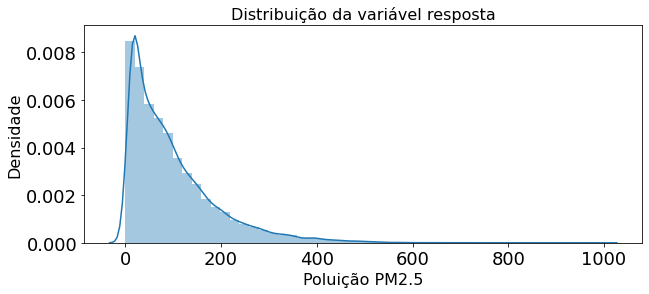

In [6]:
plt.figure(figsize=(10,4))
sns.distplot(dados_prep['PM25'])
plt.xlabel('Poluição PM2.5',size=16)
plt.ylabel('Densidade',size=16)
plt.title('Distribuição da variável resposta',size=16)
plt.show()

Nossa distribuição é `lognormal` nesse caso, como é o caso de muitas distribuições de partículas de poluentes. Se aplicarmos uma transformação `log`, a distribuição volta a ser `normal`

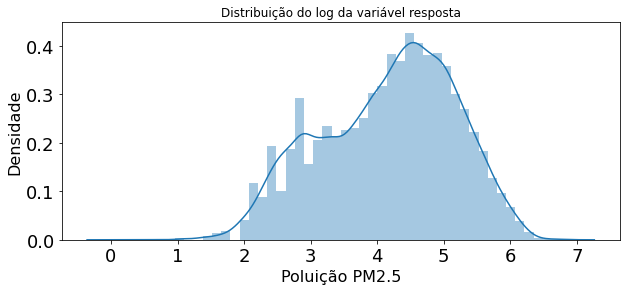

In [7]:
plt.figure(figsize=(10,4))
sns.distplot(np.log1p(dados_prep['PM25']))
plt.xlabel('Poluição PM2.5',size=16)
plt.ylabel('Densidade',size=16)
plt.title('Distribuição do log da variável resposta',size=12)
plt.show()

Apesar dessa distribuição parecer bastante comum, não conseguimos ver uma dimensão escondida nesse dataset: **a ordem**.
E esta é a primeira dica importante de um problema de série temporal: **a ordem dos dados é uma informação!**

## 1. Dataprep: Onde temos que ser mais criativos!

### 1.1 O tipo `datetime`

Em séries temporais, o formato mais importante e que exige mais a nossa atenção é o formato `datetime`.
Este formato é especial porque permite uma série de operações que seriam **muito mais difíceis** em outras linguagens!

Para converter, podemos usar a função do pandas `pd.to_datetime()`

In [78]:
#Convertendo dados em DateTime
dados_prep['data'] = pd.to_datetime(dados_prep[['year','month','day','hour']]) # Como está na ordem ano-mes-dia-hora, podemos chamar assim
dados_prep.dtypes

Obs                            int64
year                           int64
month                          int64
day                            int64
hour                           int64
PM25                         float64
Orvalho                        int64
Temperatura                  float64
Pressao                      float64
vel_vento                    float64
horas_neve                     int64
horas_chuva                    int64
PM25 hora anterior           float64
PM25 hora seguinte           float64
PM25_0                       float64
PM25_1                       float64
PM25_2                       float64
PM25_3                       float64
PM25_4                       float64
PM25_5                       float64
PM25_6                       float64
PM25_7                       float64
PM25_8                       float64
PM25_9                       float64
PM25_10                      float64
PM25_11                      float64
target                       float64
d

Para usar todo o potencial do campo `datetime`, o mais adequado é colocá-lo como índice

Agora podemos observar a variável resposta ao longo do tempo

In [ ]:
# Colocando como index
dados_prep.set_index('data',inplace=True)

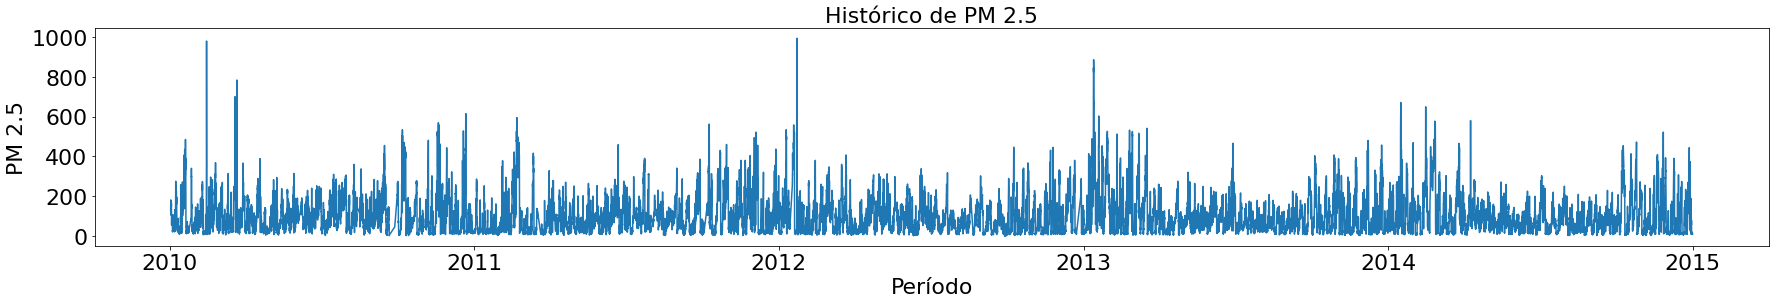

In [80]:
plt.figure(figsize=(30,4))
plt.plot(dados_prep.data,dados_prep.PM25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico de PM 2.5',size=22)

plt.show()

Os dados são bem erráticos! E se pudéssemos agrupar de alguma maneira, seria bem útil para nossas análises

### 1.1 Reagrupando os dados com `resample`

Quando temos um dataset com o **índice** sendo do tipo `datetime`, podemos começar a agrupar os dados por diferentes **intervalos de tempo**.

Para isso, usamos o método `resample`

In [11]:
# Para usarmos o resample, o campo do tipo 'datetime' precisa ser o índice
dados_prep.set_index('data',inplace=True)

In [12]:
dados_agrupados_mensal = dados_prep.resample('M') # Reagrupando pelo mês
dados_agrupados_mensal

Para termos o dataset novamente, precisamos usar alguma **função de sumarização**, semelhante ao que fazemos com o `groupby()` do Pandas

In [13]:
dados_agrupados_mensal = dados_prep.resample('M').mean() # Pela média
dados_agrupados_mensal.head()

,Obs,year,month,day,hour,PM25,Orvalho,Temperatura,Pressao,vel_vento,horas_neve,horas_chuva
data,,,,,,,,,,,,
2010-01-31,364.543645,2010.0,1.0,15.667688,11.519142,90.442573,-16.776417,-6.364472,1028.532925,39.381133,0.546708,0.000000
2010-02-28,1080.532042,2010.0,2.0,14.500745,11.514158,97.233979,-13.154993,-1.918033,1023.769001,13.482191,0.132638,0.000000
2010-03-31,1772.352609,2010.0,3.0,15.327221,11.499295,94.100141,-8.610719,2.983075,1022.173484,24.122863,0.251058,0.110014
2010-04-30,2521.469359,2010.0,4.0,15.540390,11.500000,80.029248,-3.291086,10.805014,1017.160167,58.074666,0.000000,0.253482
2010-05-31,3250.563094,2010.0,5.0,15.922659,11.419267,86.899593,7.580733,20.856174,1007.850746,21.602564,0.000000,0.472185


Temos agora um dataset com uma linha por `mês`. Vamos plotar novamente o gráfico

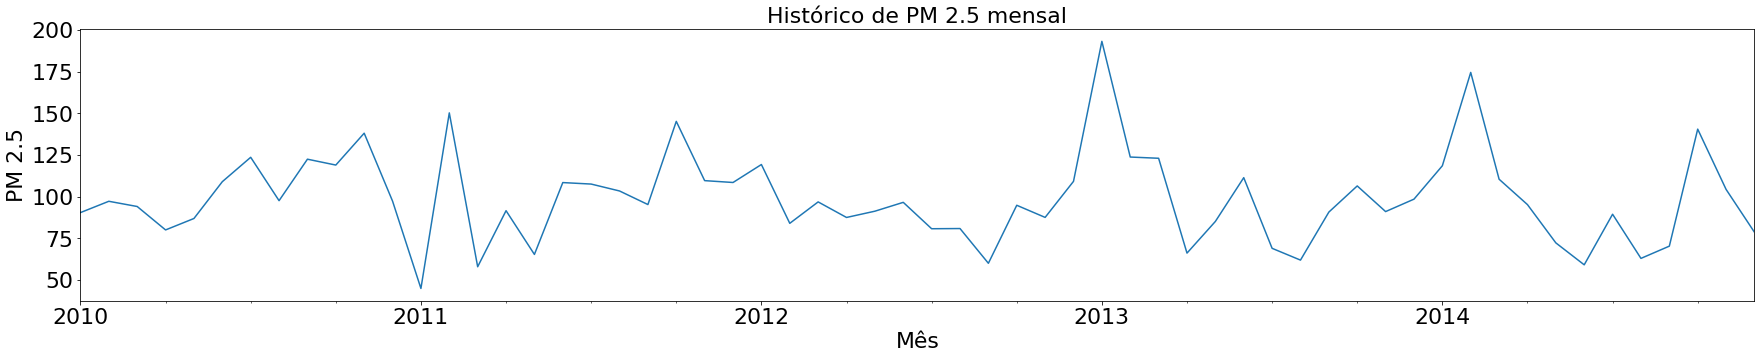

In [14]:
plt.figure(figsize=(30,5))
dados_agrupados_mensal.PM25.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Mês',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico de PM 2.5 mensal',size=22)
plt.show()

Por termos agrupado mais os dados, temos menos variação entre os pontos! 

In [15]:
# Mais exemplos de agrupamentos (não precisa ser bonito!)
dados_anuais = dados_prep.resample('Y').mean()
dados_trimestrais = dados_prep.resample('Q').mean()
dados_a_cada_5_meses = dados_prep.resample('5M').mean()
dados_mensais = dados_prep.resample('M').mean()
dados_semanais = dados_prep.resample('W').mean()
dados_diarios = dados_prep.resample('D').mean()

Para continuar nosso modelo, vamos usar os dados `horários`

In [16]:
dados_agrupados = dados_prep

### 1.2 Suavizando os gráficos com `médias móveis` e o `rolling`

Como a **ordem** do dataset também é uma informação, podemos fazer cálculos entre as linhas para capturar tendências.

Uma forma fácil de fazer cálculos com as últimas `n` linhas de um dataset é o método `.rolling`, do Pandas

In [17]:
dados_agrupados['PM2.5 média últimas 24 horas'] = dados_agrupados.PM25.rolling(24).mean() # Média das últimas 24 horas
dados_agrupados['PM2.5 soma últimas 24 horas'] = dados_agrupados.PM25.rolling(24).sum() # Soma das últimas 24 horas
dados_agrupados['PM2.5 máximo últimas 24 horas'] = dados_agrupados.PM25.rolling(24).max() # Maior valor das últimas 24 horas
dados_agrupados['PM2.5 mínimo últimas 24 horas'] = dados_agrupados.PM25.rolling(24).min() # Menor valor das últimas 24 horas

In [18]:
dados_agrupados.tail()

,Obs,year,month,day,hour,PM25,Orvalho,Temperatura,Pressao,vel_vento,horas_neve,horas_chuva,PM2.5 média últimas 24 horas,PM2.5 soma últimas 24 horas,PM2.5 máximo últimas 24 horas,PM2.5 mínimo últimas 24 horas
data,,,,,,,,,,,,,,,,
2014-12-31 19:00:00,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,231.97,0,0,11.291667,271.0,26.0,7.0
2014-12-31 20:00:00,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,237.78,0,0,10.625000,255.0,20.0,7.0
2014-12-31 21:00:00,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,242.70,0,0,10.208333,245.0,20.0,7.0
2014-12-31 22:00:00,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,246.72,0,0,10.208333,245.0,20.0,7.0
2014-12-31 23:00:00,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,249.85,0,0,10.041667,241.0,20.0,7.0


Vamos agora comparar os dados diários com a média móvel das últimas 24 horas

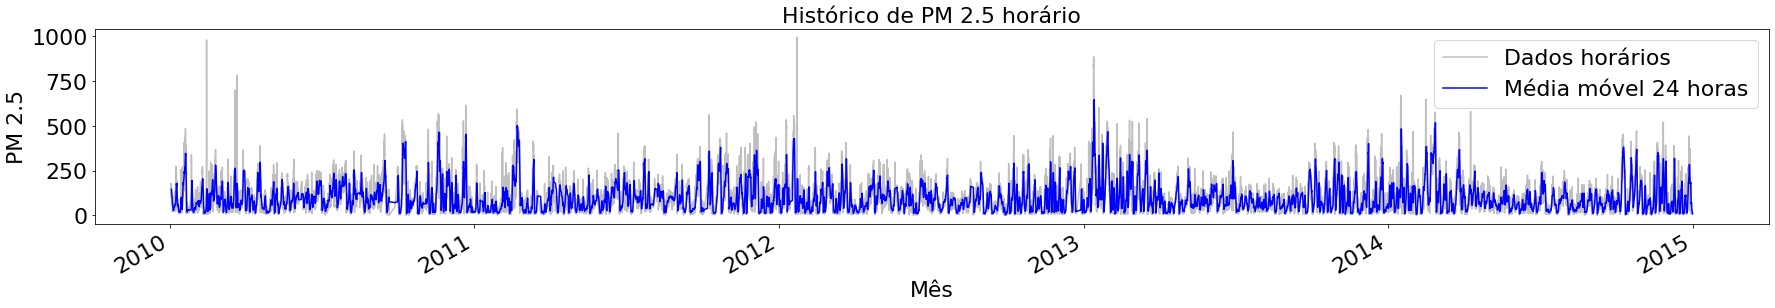

In [19]:
plt.figure(figsize=(30,4))
dados_agrupados.PM25.plot(c='grey',alpha=0.5) # Dados reais
dados_agrupados['PM2.5 média últimas 24 horas'].plot(c='blue') # Dados reais
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Mês',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico de PM 2.5 horário',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

Como podemos ver da linha azul, a média móvel captura os saltos e quedas da série temporal, porém sem grandes oscilações

### 1.3 Feature engineering usando a `ordem do dataset`

Como falamos no início, a **ordem** do Dataset de uma série temporal guarda uma informação importante, e vamos agora usá-la em todo o seu potencial!

Será que o valor da poluição (`PM25`) de um determinada hora está relacionado com o valor da poluição medido nas horas anteriores?

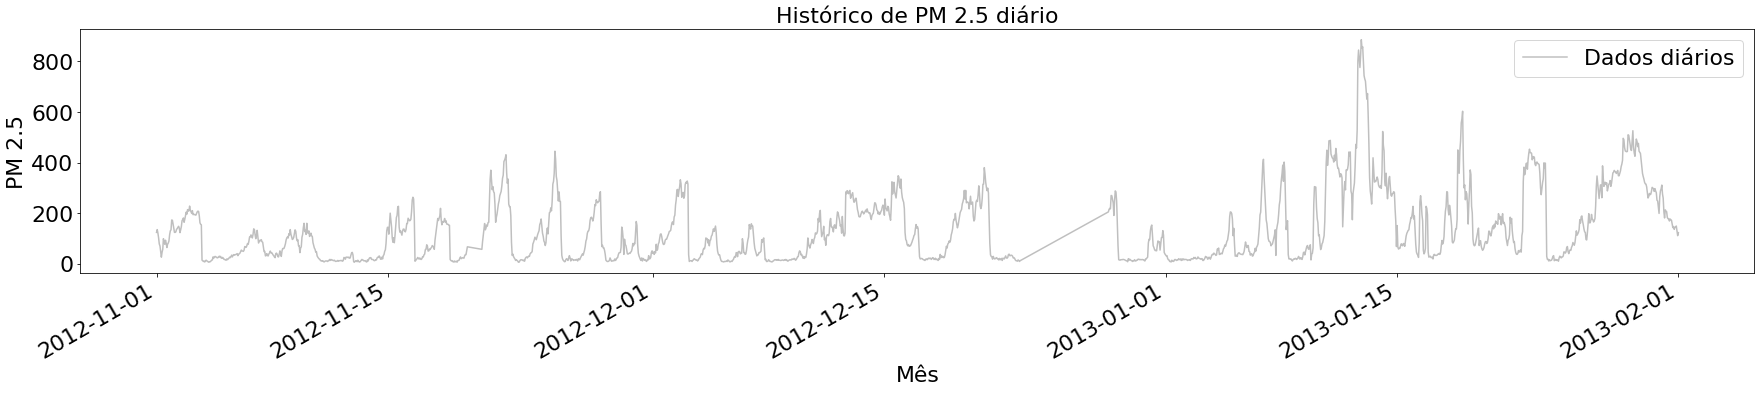

In [20]:
# Corte do plot
dados_plot = dados_agrupados[(dados_agrupados.index>='2012-11') & (dados_agrupados.index<='2013-02')]

plt.figure(figsize=(30,5))
dados_plot.PM25.plot(c='grey',alpha=0.5) # Dados reais
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Mês',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico de PM 2.5 diário',size=22)
plt.legend(['Dados diários'],fontsize=22)
plt.show()

O pico registrado no **início de 2013** parece indicar isso! Sendo assim, podemos usar os registros **das horas anteriores** como features para ajudar na previsão do dia seguinte!

Podemos caputrar a informação de linhas acima ou abaixo de uma linha específica usando o método `pd.shift()`

In [21]:
dados_agrupados['PM25 hora anterior'] = dados_agrupados.PM25.shift(1) # Uma linha para cima
dados_agrupados['PM25 hora seguinte'] = dados_agrupados.PM25.shift(-1) # Uma linha para baixo
dados_agrupados.head()

,Obs,year,month,day,hour,PM25,Orvalho,Temperatura,Pressao,vel_vento,horas_neve,horas_chuva,PM2.5 média últimas 24 horas,PM2.5 soma últimas 24 horas,PM2.5 máximo últimas 24 horas,PM2.5 mínimo últimas 24 horas,PM25 hora anterior,PM25 hora seguinte
data,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0,NaN,NaN,NaN,NaN,NaN,148.0
2010-01-02 01:00:00,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0,NaN,NaN,NaN,NaN,129.0,159.0
2010-01-02 02:00:00,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0,NaN,NaN,NaN,NaN,148.0,181.0
2010-01-02 03:00:00,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0,NaN,NaN,NaN,NaN,159.0,138.0
2010-01-02 04:00:00,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0,NaN,NaN,NaN,NaN,181.0,109.0


Agora que descobrimos essa função, podemos aplicá-la para vários dias e colunas!

In [22]:
# Deletando colunas de exemplo
dados_agrupados.drop(['PM2.5 média últimas 24 horas',
                     'PM2.5 soma últimas 24 horas',
                     'PM2.5 máximo últimas 24 horas',
                     'PM2.5 mínimo últimas 24 horas'],axis=1,inplace=True)

In [23]:
def constroi_features_defasadas(base,lista_features,defasagem_maxima):
    # Constrói features defasadas com base na base original
    # Copia a base
    base_cop = base.copy()
    for feat in lista_features:       
        for i in range(1,defasagem_maxima+1):
            base_cop[str(feat)+'_def_'+str(i)] = base_cop[feat].shift(i)
    return base_cop

In [25]:
dados_agrupados_eng = constroi_features_defasadas(dados_agrupados,['PM25','Orvalho','Temperatura',
                                                                   'Pressao','vel_vento','horas_neve','horas_chuva'],24)

In [26]:
print('Colunas antes do feature engineering: {}'.format(dados_agrupados.shape[-1]))
print('Colunas antes do feature engineering: {}'.format(dados_agrupados_eng.shape[-1]))

Colunas antes do feature engineering: 14
Colunas antes do feature engineering: 182


Apenas usando features do *passado*, já conseguimos multiplicar o número de features praticamente por 20!

### 1.4 Construção da variável resposta também usando defasagem

Assim como podemos construir as features usando o *passado* da base, podemos construir a variável resposta usando o *futuro da base* também!

In [27]:
def construcao_target(base,nome_feature_target,periodos_considerados):
    # Constrói a variável resposta usando feature_target agrupado pelo número periodos_considerados
    cols_target = []
    for i in range(periodos_considerados):
        nome_feature = nome_feature_target+'_'+str(i)
        cols_target.append(nome_feature)
        base[nome_feature] = base[nome_feature_target].shift(-i)
    # Consolidação final
    base['target'] = base[cols_target].mean(axis=1)
    # Retorna a base apenas com a coluna target, desconsiderando as demais
    return base.drop(cols_target,axis=1)
                   

Vamos definir que nossa target será a previsão do nível de poluição `PM25` nas próximas **12 horas**

In [28]:
base_com_target = construcao_target(dados_agrupados,'PM25',12)

In [29]:
base_com_target.head()

,Obs,year,month,day,hour,PM25,Orvalho,Temperatura,Pressao,vel_vento,horas_neve,horas_chuva,PM25 hora anterior,PM25 hora seguinte,target
data,,,,,,,,,,,,,,,
2010-01-02 00:00:00,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0,NaN,148.0,136.416667
2010-01-02 01:00:00,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0,129.0,159.0,138.000000
2010-01-02 02:00:00,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0,148.0,181.0,139.333333
2010-01-02 03:00:00,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0,159.0,138.0,139.250000
2010-01-02 04:00:00,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0,181.0,109.0,137.000000


### 1.5 Construindo features de sazonalidade

Apesar de estarmos construindo muitas features temporais, não temos nenhuma informação nas variáveis do próprio **tempo**! Mas podemos incluí-las como features também

In [30]:
# Incluindo features de informação do tempo
base_com_target['mes'] = base_com_target.index.month
base_com_target['dia_da_semana'] = base_com_target.index.dayofweek

In [31]:
base_com_target.head()

,Obs,year,month,day,hour,PM25,Orvalho,Temperatura,Pressao,vel_vento,horas_neve,horas_chuva,PM25 hora anterior,PM25 hora seguinte,target,mes,dia_da_semana
data,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0,NaN,148.0,136.416667,1,5
2010-01-02 01:00:00,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0,129.0,159.0,138.000000,1,5
2010-01-02 02:00:00,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0,148.0,181.0,139.333333,1,5
2010-01-02 03:00:00,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0,159.0,138.0,139.250000,1,5
2010-01-02 04:00:00,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0,181.0,109.0,137.000000,1,5


## 2. Modelagem: Hora de usar o que sabemos (e aprender o que não sabemos)

Como comentamos no início da apresentação, queremos prever o nível de poluição observado nas **próximas 12 horas** com base nas observações feitas até ___ dias atrás

### 2.1 Recapitulando e aplicando o DataPrep

Como já temos funções que construem **features no passado** e nossa **variável resposta**, vamos usar essas funções!

In [32]:
# Partindo da nossa base inicial (dados horários)
base_inicial = dados_prep

# Eliminando missings
base_inicial_mis = base_inicial.dropna()

# Vamos construir features até 24 horas atrás
base_inicial_eng = constroi_features_defasadas(base_inicial_mis,
                                               ['PM25','Orvalho','Temperatura','Pressao','vel_vento','horas_neve','horas_chuva']
                                               ,24)

# E também uma variável target nas próximas 12 horas, excluindo linhas em que não é possível calcular a defasagem
base_inicial_eng_target = construcao_target(base_inicial_eng,'PM25',12).dropna()

In [33]:
# Checando a forma da base final
base_inicial_eng_target.head()

,Obs,year,month,day,hour,PM25,Orvalho,Temperatura,Pressao,vel_vento,...,horas_chuva_def_15,horas_chuva_def_16,horas_chuva_def_17,horas_chuva_def_18,horas_chuva_def_19,horas_chuva_def_20,horas_chuva_def_21,horas_chuva_def_22,horas_chuva_def_23,horas_chuva_def_24
data,,,,,,,,,,,,,,,,,,,,,
2010-01-03 01:00:00,50,2010,1,3,1,63.0,-8,-6.0,1026.0,61.69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03 02:00:00,51,2010,1,3,2,65.0,-8,-7.0,1026.0,65.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03 03:00:00,52,2010,1,3,3,55.0,-8,-7.0,1025.0,68.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03 04:00:00,53,2010,1,3,4,65.0,-8,-7.0,1024.0,72.86,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03 05:00:00,54,2010,1,3,5,83.0,-9,-8.0,1024.0,76.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Por fim, vamos separar os dados em features e targets

In [34]:
X = base_inicial_eng_target.drop('target',axis=1)
y = base_inicial_eng_target.target

### 2.2 A crossvalidação em séries temporais

Em seguida, iremos separar o nosso conjunto de dados em treino e teste, para então começarmos nossas modelagens

a questão é: **Como** fazer essa separação?

<center> <img src="https://miro.medium.com/max/601/1*PdwlCactbJf8F8C7sP-3gw.png" width=1000>

<center> Em um problema clássico, separaríamos o conjunto em treino e teste, e dentro do treino poderíamos fazer <b> validação cruzada</b> para encontrar o melhor modelo e os melhores hiperparâmetros deste modelo.

<center> Podemos usar essa abordagem em séries temporais?

<center> <img src="https://i.stack.imgur.com/kb4zU.png" width=1500>
<center> Se usarmos uma abordagem similar para séries temporais, podemos cometer o erro de <b>vazamento de informação</b>, pois estaremos usando dados futuros para prever dados passados, podendo tornar nosso modelo confiante demais!

Felizmente, temos uma solução para isso que é a **validação cruzada temporal**!!
<center> <img src = "http://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/01/image3-4.png" width=1100>
<p>
    Na prática, a cada <b>fold</b> consideraremos o passado para treinamento e o futuro imediatamente após como validação, evitando assim o vazamento de informações
</p>


No `scikit-learn`, podemos usar o módulo `TimeSeriesSplit` para fazer este tipo de validação cruzada

In [35]:
from sklearn.model_selection import TimeSeriesSplit

ts = TimeSeriesSplit(n_splits=5).split(X,y)
ts

<generator object TimeSeriesSplit.split at 0x00000240D2EBFA50>

Temos um objeto `split`, como em um `KFold` usado em validações cruzadas de problemas não temporais. Vamos checar o tamanho de cada fold a cada iteração

In [36]:
i=1
for train_index, test_index in TimeSeriesSplit(n_splits=5).split(X,y):
    #print(train_index)
    print('Fold '+str(i))
    print('Conjunto de treino: '+str(len(X.iloc[train_index]))+' registros')
    print('Conjunto de teste: '+str(len(X.iloc[test_index]))+' registros')
    print('---')
    i = i+1

Fold 1
Conjunto de treino: 6956 registros
Conjunto de teste: 6953 registros
---
Fold 2
Conjunto de treino: 13909 registros
Conjunto de teste: 6953 registros
---
Fold 3
Conjunto de treino: 20862 registros
Conjunto de teste: 6953 registros
---
Fold 4
Conjunto de treino: 27815 registros
Conjunto de teste: 6953 registros
---
Fold 5
Conjunto de treino: 34768 registros
Conjunto de teste: 6953 registros
---


Mas mesmo com essa possibilidade, ainda precisamos separar dados que o modelo nunca terá acesso, mesmo na validação cruzada. Como temos dados temporais e queremos testar a performance no futuro, faremos uma separação **Out of time**

In [37]:
# Temos quatro anos na base (2010-2014), então iremos separar os últimos 6 meses para teste
corte_treino_teste = '2014-07-01'

X_train = X[X.index<=corte_treino_teste]
X_test = X[X.index>corte_treino_teste]

y_train = y[y.index<=corte_treino_teste]
y_test = y[y.index>corte_treino_teste]

print('Tamanho do treino '+str(len(X_train)))
print('Tamanho do teste '+str(len(X_test)))

Tamanho do treino 37383
Tamanho do teste 4338


### 2.3 Escolhendo uma métrica e encontrando o modelo ideal

Agora que temos os dados tratados e separados, vamos escolher uma métrica adequada para avaliar séries temporais

Vamos apenas relembrar algumas métricas importantes de regressão:

* `mean_squared_error` ou MSE: Média das diferenças entre a variável verdadeira e a predita **ao quadrado**. Quanto menor, melhor!
* `mean_absolute_error` ou MAE: Média das diferenças entre a variável verdadeira e a predita **em módulo**. Quanto menor, melhor!
* `root_mean_squared_error` ou RMSE: Raíz quadrada do `mean_squared_error`. Quanto menor, melhor!
* `r2_score` ou apenas r2: Percentual da variância total da variável resposta que pode ser explicada pelo modelo **além do que a média já explica**. Quanto maior, melhor! <p>

Em séries temporais, há uma grande preferência por uso de métricas **com escala**, como o `MAE` ou o `RMSE`. Para este problema, inicialmente, iremos usar o `MAE`

Vamos escolher agora alguns modelos padrão para avaliar a nossa métrica e escolher o melhor

In [38]:
modelos_candidatos = {'Árvore':DecisionTreeRegressor(max_depth=5),
                      'RandomForest':RandomForestRegressor(max_depth=5),
                      'LGBM':LGBMRegressor(max_depth=5)
                     }

Vamos usar nossa crossvalidação temporal e a métrica MAE para avaliar a performance destes modelos e fazer um gráfico

In [39]:
avaliacao = {}
for nome,model in modelos_candidatos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model, # Escolhendo o nosso modelo da vez
                            X_train, y_train, # Nossos dados, excluindo o teste
                            cv=TimeSeriesSplit(n_splits=5), # Validação cruzada temporal
                            scoring='neg_mean_absolute_error', # Usando a métrica MAE
                           n_jobs=8 # Número de processadores, para ser mais rápido
                           ).mean() # Tirando a média de todos os folds
    avaliacao[nome] = -score # -score e não score para tornar o número positivo

In [40]:
avaliacao

{'Árvore': 35.270521377193916,
 'RandomForest': 29.89277116370235,
 'LGBM': 28.66227910755099}

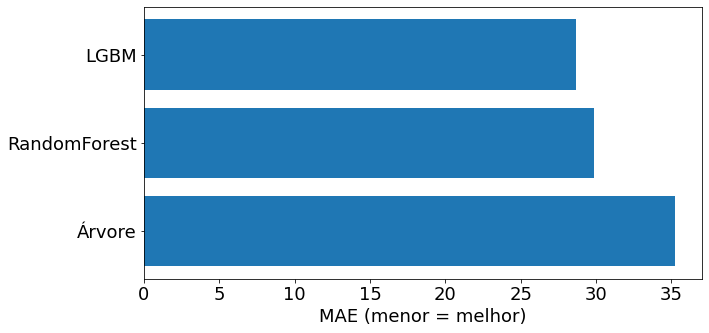

In [41]:
plt.figure(figsize=(10,5))
plt.barh(*zip(*avaliacao.items()))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('MAE (menor = melhor)',size=18)
plt.show()

Pelo gráfico acima, o modelo que parece ter sido o melhor com os hiperparâmetros usados é o `LGBM`! Então vamos escolher este modelo para otimização

### 2.4 Seleção de variáveis: inferindo a janela ideal de defasagem

Na grande maioria dos problemas de séries temporais, as bases de dados não são tão grandes assim, exceto em casos em que a captura de dados é muito alta (dados em segundos, milisegundos, etc.) Entretanto, dependendo do cenário, podemos ter bases de dados com muitas features

In [42]:
# Vamos definir uma função de dataprep

def dataprep(base, defasagem_passado, defasagem_futuro):
    # Partindo da nossa base inicial (dados horários)
    b1 = base.copy()
    # Eliminando missings
    b2 = b1.dropna()
    # Vamos construir features até defasagem_passado períodos atrás
    b3 = constroi_features_defasadas(b2,['PM25','Orvalho','Temperatura','Pressao','vel_vento','horas_neve','horas_chuva'],defasagem_passado)
    # E também uma variável target nos defasagem_futuro períodos seguintes
    b4 = construcao_target(b3,'PM25',defasagem_futuro)
    return b4.dropna()

In [43]:
# testando alguns tamanhos de base
for i in [10,20,30,40,50,60]:
    base_prep = dataprep(dados_agrupados,i,12)
    print('Número de features com '+str(i)+' defasagens: {}'.format(base_prep.shape[-1]))

Número de features com 10 defasagens: 85
Número de features com 20 defasagens: 155
Número de features com 30 defasagens: 225
Número de features com 40 defasagens: 295
Número de features com 50 defasagens: 365
Número de features com 60 defasagens: 435


Até mesmo pensando em implantação de modelos, muitas features podem tornar o modelo pesado e complexo, então de alguma maneira temos que fazer uma seleção de variáveis baseada nos resultados que temos. Uma forma bacana é analisarmos se nossa performance melhora muito na medida em que usamos mais features para o modelo

In [44]:
avaliacao = []
for i in range(20,400,20): # Testando de 20 a 400 horas de defasagem, variando de 20 em 20
    # Prepara a base
    base_avaliacao = dataprep(dados_agrupados,i,12) # i defasagens para trás, 12 para frente
    X = base_avaliacao.drop('target',axis=1)
    y = base_avaliacao.target
    X_train = X[X.index<=corte_treino_teste]
    X_test = X[X.index>corte_treino_teste]
    y_train = y[y.index<=corte_treino_teste]
    y_test = y[y.index>corte_treino_teste]
    score = cross_val_score(LGBMRegressor(max_depth=5), # Escolhendo o nosso modelo da vez
                            X_train, y_train, # Nossos dados, excluindo o teste
                            cv=TimeSeriesSplit(n_splits=5), # Validação cruzada temporal
                            scoring='neg_mean_absolute_error', # Usando a métrica MAE
                            n_jobs=8 # Número de processadores, só para ir mais rápido
                           ).mean() # Tirando a média de todos os folds
    avaliacao.append((i,-score))


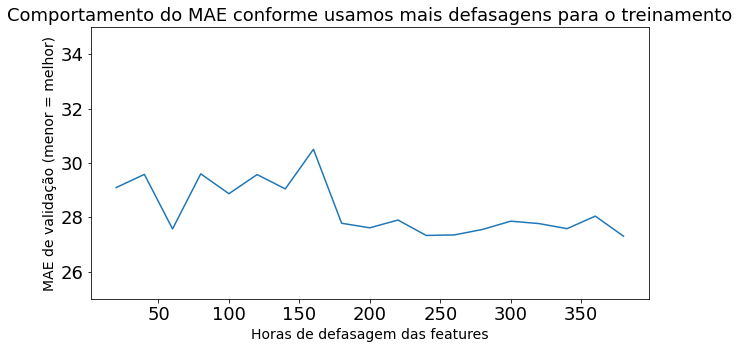

In [45]:
# Exemplo de bases com muitas features
plt.figure(figsize=(10,5))
plt.plot(*zip(*avaliacao))
plt.xlabel('Horas de defasagem das features',size=14)
plt.ylabel('MAE de validação (menor = melhor)',size=14)
plt.ylim([25,35])
plt.title('Comportamento do MAE conforme usamos mais defasagens para o treinamento',size=18)
plt.show()

Pelo gráfico acima, vemos que usando mais features defasadas não ganhamos tanta performance. Sendo assim, vamos travar em **72 horas** de defasagem

In [46]:
base_final = dataprep(dados_prep,72,12)
X = base_final.drop('target',axis=1)
y = base_final.target

# Temos quatro anos na base (2010-2014), então iremos separar os últimos 6 meses para teste
corte_treino_teste = '2014-07-01'

X_train = X[X.index<=corte_treino_teste]
X_test = X[X.index>corte_treino_teste]

y_train = y[y.index<=corte_treino_teste]
y_test = y[y.index>corte_treino_teste]

print('Tamanho do treino '+str(len(X_train)))
print('Tamanho do teste '+str(len(X_test)))

Tamanho do treino 37335
Tamanho do teste 4338


In [47]:
X_train.head()

,Obs,year,month,day,hour,PM25,Orvalho,Temperatura,Pressao,vel_vento,...,horas_chuva_def_63,horas_chuva_def_64,horas_chuva_def_65,horas_chuva_def_66,horas_chuva_def_67,horas_chuva_def_68,horas_chuva_def_69,horas_chuva_def_70,horas_chuva_def_71,horas_chuva_def_72
data,,,,,,,,,,,,,,,,,,,,,
2010-01-05 01:00:00,98,2010,1,5,1,34.0,-26,-18.0,1035.0,205.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05 02:00:00,99,2010,1,5,2,27.0,-26,-19.0,1035.0,208.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05 03:00:00,100,2010,1,5,3,25.0,-27,-18.0,1035.0,213.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05 04:00:00,101,2010,1,5,4,28.0,-27,-19.0,1035.0,218.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05 05:00:00,102,2010,1,5,5,28.0,-27,-16.0,1034.0,4.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.5 A escolha da métrica: comparações relativas

Um dos pontos mais importantes da validação cruzada de séries temporais é a escolha da métrica. Isso importa bastante pois  **o tamanho do conjunto de treino varia a cada iteração**

Vamos avaliar isso usando o `cross_val_score`

In [48]:
scores = -cross_val_score(LGBMRegressor(), # Escolhendo o nosso modelo da vez
                    X_train, y_train, # Nossos dados, excluindo o teste
                    cv=TimeSeriesSplit(n_splits=10), # Validação cruzada temporal
                    scoring='neg_mean_absolute_error', # Usando a métrica MAE
                   n_jobs=8 # Número de processadores, para rodar mais rápido
                         ) # Tirando a média de todos os folds


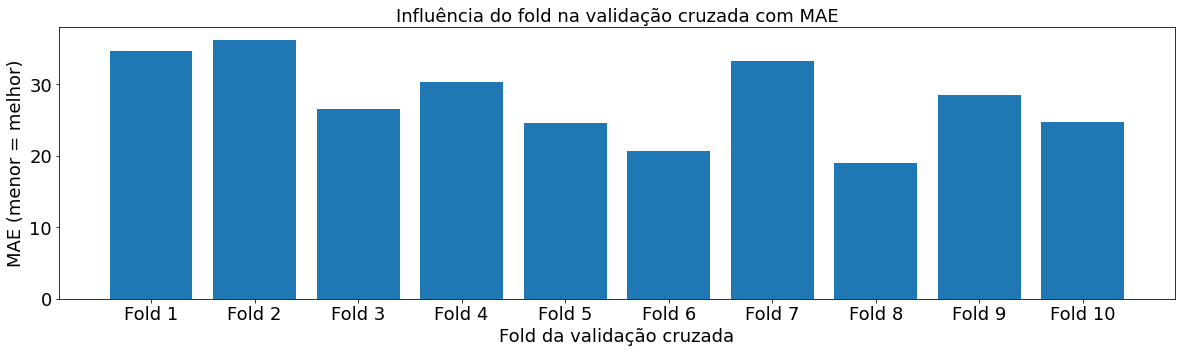

In [49]:
plt.figure(figsize=(20,5))
plt.bar(height=scores,x=['Fold '+str(i) for i in range(1,11)])
plt.xlabel('Fold da validação cruzada',size=18)
plt.ylabel('MAE (menor = melhor)',size=18)
plt.title('Influência do fold na validação cruzada com MAE',size=18)
plt.show()

De alguma maneira, quanto menos dados temos para treinar o modelo, mais **underfitting** teremos, e a nossa métrica precisa ser robusta a isso para evitarmos conclusões incorretas!

Uma solução simples para isso é comparar a nossa métrica com a métrica de um **modelo de base**. No caso do `r2_score`, o modelo de base é uma **média simples** da variável resposta. Qual poderia ser um análogo disso em séries temporais?

Vamos então calcular para todos os dados a **média móvel** do período de defasagem para o passado, e usar a métrica deste modelo "simples" para avaliar o nosso!

In [50]:
y_mediamovel = y_test.rolling(window=72,closed='left').mean().dropna() #Eliminando horas sem média móvel

# Selecionando para validação os mesmos índices
X_valid = X.loc[y_mediamovel.index]
y_valid = y.loc[y_mediamovel.index]


Vamos agora repetir a validação cruzada com Time Series, agora comparando nossa métrica com a da média móvel

In [51]:
metricas = []
for index_train, index_test in TimeSeriesSplit(n_splits=10).split(X_valid,y_valid):
    # Dados de treino
    x_tr = X_valid.iloc[index_train]
    y_tr = y_valid.iloc[index_train]
    x_te = X_valid.iloc[index_test]
    y_te = y_valid.iloc[index_test]
    y_mdmv = y_mediamovel[index_test]
    # Treinando um modelo e ajustando aos dados de treino
    model = LGBMRegressor().fit(x_tr,y_tr)
    # Prevendo nos dados de teste
    y_pr = model.predict(x_te)
    # Calculando a métrica (MAE) no teste 
    mae_model = mean_absolute_error(y_te,y_pr)
    mae_mdmv = mean_absolute_error(y_te,y_mdmv)
    mae_relativo = mae_model/mae_mdmv
    metricas.append(mae_relativo)

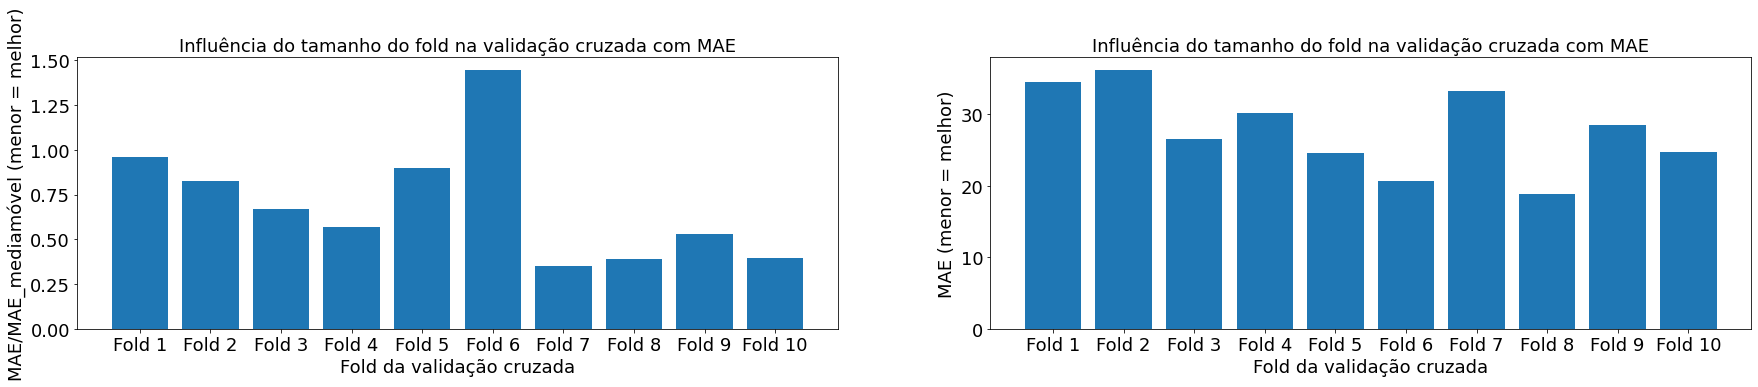

In [52]:
fig, ax = plt.subplots(1,2, figsize=(30,5))
ax[0].bar(height=metricas,x=['Fold '+str(i) for i in range(1,11)])
ax[0].set_xlabel('Fold da validação cruzada',size=18)
ax[0].set_ylabel('MAE/MAE_mediamóvel (menor = melhor)',size=18)
ax[0].set_title('Influência do tamanho do fold na validação cruzada com MAE',size=18)
ax[1].bar(height=scores,x=['Fold '+str(i) for i in range(1,11)])
ax[1].set_xlabel('Fold da validação cruzada',size=18)
ax[1].set_ylabel('MAE (menor = melhor)',size=18)
ax[1].set_title('Influência do tamanho do fold na validação cruzada com MAE',size=18)
plt.show()

Agora a métrica é mais equilibrada, e mostra inclusive quando nosso modelo oscila de performance junto com a média móvel

### 2.6 Otimização de Hiperparâmetros e modelo final

Agora com nosso modelo escolhido, vamos otimizar os hiperparâmetros e plotar nosso modelo final! Para isso, vamos usar o `GridSearchCV` específico para o LGBM

In [53]:
param_grid = {
'learning_rate':[.1,.15,.2,.25],
'n_estimators':[10,100,150,200],
'num_leaves':[20,220,260,300]
}


In [54]:
from sklearn.model_selection import GridSearchCV

In [58]:
rcv = GridSearchCV(LGBMRegressor(),param_grid=param_grid,cv=TimeSeriesSplit(n_splits=3),
                        scoring='neg_mean_absolute_error',verbose=True,n_jobs=8)
rcv.fit(X,y)

rcv.best_params_

{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 20}

In [56]:
melhores_parametros = {
'learning_rate':.1,
'n_estimators':100,
'num_leaves':20
}

In [59]:
modelo = LGBMRegressor(**melhores_parametros).fit(X_train,y_train)
y_pred_final = pd.Series(modelo.predict(X),index=X.index)

<AxesSubplot:xlabel='data'>

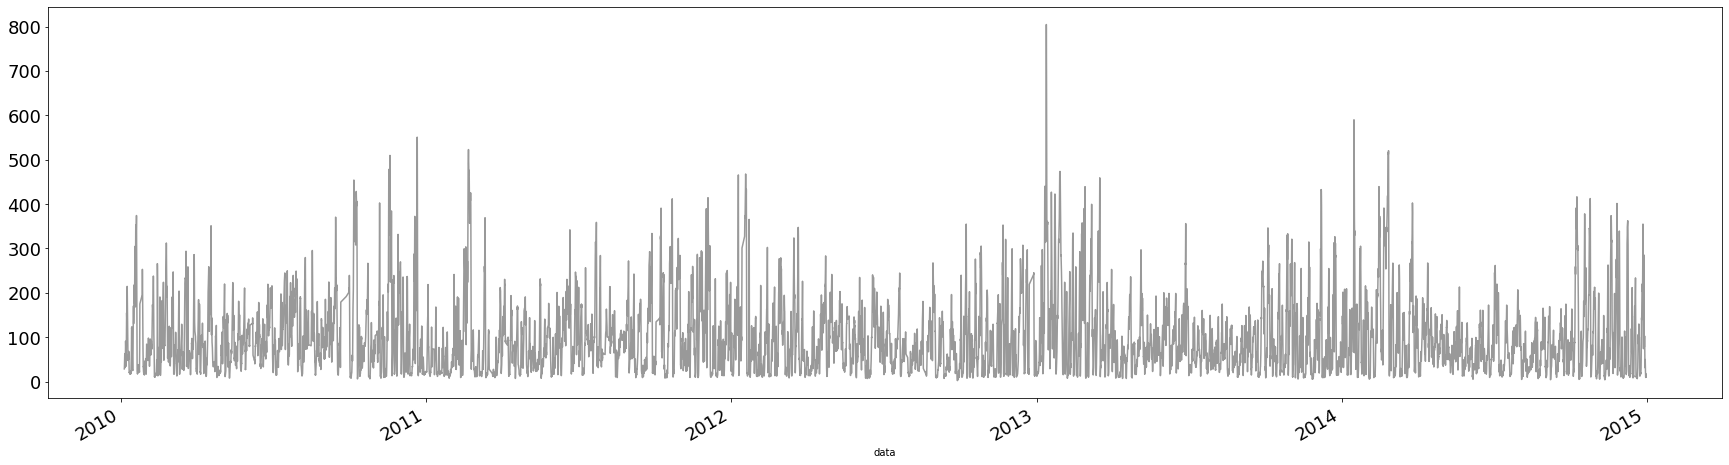

In [60]:
plt.figure(figsize=(30,8))
y.plot(c='grey',alpha=0.8) # Dados reais

Plotando os dados de treino e teste para 5 dias do conjunto de teste

In [61]:
x_pl = X[(X.index>='2014-08-20') & (X.index<='2014-08-26')]

y_plot = y[x_pl.index]
y_preds = y_pred_final[x_pl.index]
y_mdmv_plot = y_mediamovel[x_pl.index]

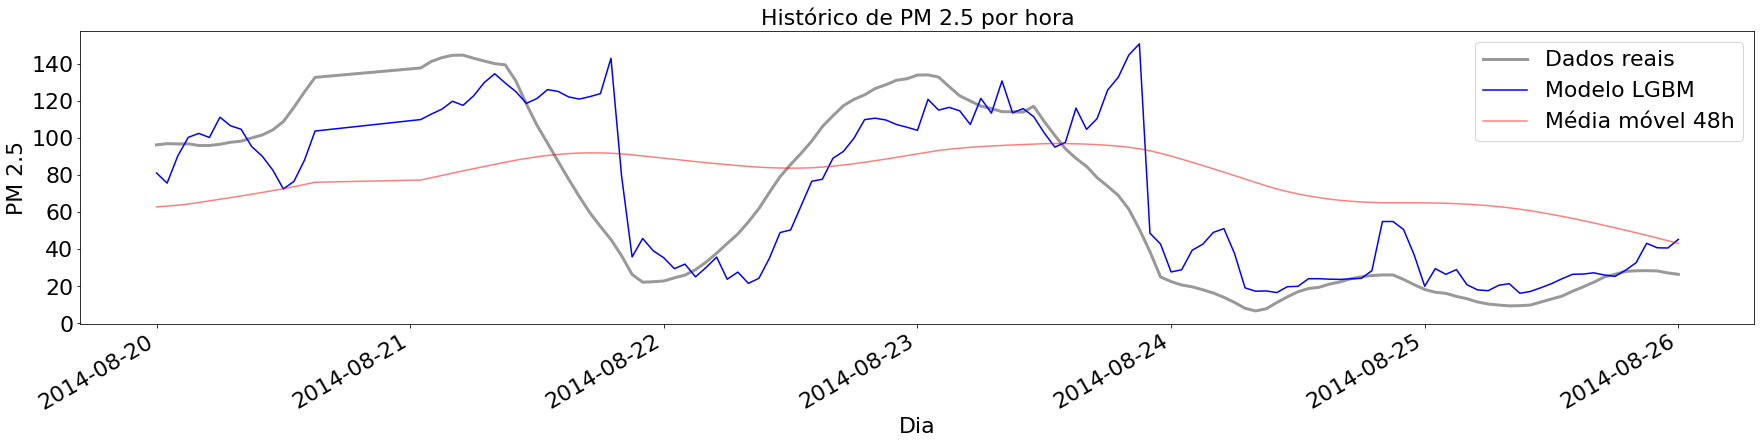

In [62]:
plt.figure(figsize=(30,6))
y_plot.plot(c='grey',alpha=0.8,linewidth=3) # Dados reais
y_preds.plot(c='blue') # Dados reais
y_mdmv_plot.plot(c='red',alpha=0.5) # Dados reais
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dia',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico de PM 2.5 por hora',size=22)
plt.legend(['Dados reais','Modelo LGBM','Média móvel 48h'],fontsize=22)
plt.show()

De fato, nosso modelo funciona melhor do que uma média móvel e capturou tendências dos dados!

Avaliando performances no treino e no teste

In [63]:
y_train_pred = modelo.predict(X_train)
print('Performance do melhor LGBM no treino')
print(mean_absolute_error(y_train,y_train_pred))
# Calculando a métrica no teste
y_test_pred = modelo.predict(X_test)
print('Performance do melhor LGBM no teste')
print(mean_absolute_error(y_test,y_test_pred))

Performance do melhor LGBM no treino
19.539235868860295
Performance do melhor LGBM no teste
22.580793668829116


## 3. Indo além: Usando o _____ que há em séries temporais!

Vamos tentar ir um pouco além!

### 3.1 Redes Neurais Recorrentes e a importância da ordem

Agora que já conseguimos construir um modelo do começo ao fim e tomando os devidos cuidados, podemos partir para tentar usar outros tipos de modelos mais avançados e desafiar nossa solução.

Vamos tentar elevar a qualidade do nosso modelo tentando treinar uma `Rede Neural`!

<center> 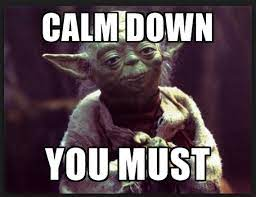

Mas calma, se você nunca usou ou viu redes neurais, sem problema! A ideia é mostrar um tipo específico de Rede Neural que pode carregar uma informação que até agora não usamos, que é a `Rede Neural Recorrente`

Na `Rede Neural Recorrente`, a **ordem** cronológica dos dados é levada em consideração, de forma que é um algoritmo utilizado em muitas situações onde a posição relativa dos dados importa (Texto, por exemplo).

<center> <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-longtermdependencies.png" width=1000>

No nosso, a ordem em que foram observadas as propriedades atmosféricas importa também! Então este modelo pode nos ajudar

Para usar Redes Neurais, vamos usar outro pacote, o `Keras`, uma distribuição que funciona sobre o `TensorFlow`

In [64]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM # Long Short Term Memory
from keras.layers import Bidirectional
from keras.layers import Dropout # Regularização
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping # Regularização

Usando o Keras, podemos construir uma rede neural **adicionando camadas uma após a outra**, de forma que no fim o modelo irá treinar os melhores pesos que resolvem o nosso problema. Apenas para recapitular:
* Construímos nossa variável resposta como sendo o valor médio de `PM 2.5` nas 12 horas seguintes
* Consideramos features de até **72 horas anteriores** ao evento
* Até o momento, nenhum modelo **entende que essa ordem existe**

Quando adicionamos uma camada `LSTM` à rede neural, estamos dizendo que a **ordem** dos dados deve afetar a resposta, poranto iremos ganhar uma nova camada de impacto em relação aos demais modelos

Para treinar um modelo no Keras, por ser uma rede neural, temos que fazer mais dois tratamentos:
* Escala dos dados, pois não é um modelo robusto a escala
* Adicionar uma dimensão (para se tornar um tensor), mesmo que tenha dimensão 1

In [65]:
# Treinando um escalador
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train).reshape(X_train.shape[0],1,X_train.shape[1])
X_test_sc = sc.transform(X_test).reshape(X_test.shape[0],1,X_test.shape[1])

No `keras`, primeiro instanciamos nosso objeto Rede Neural, para então treiná-lo. Para isso, temos que definir algumas coisas:
* Quantas (e quais) camadas nossa rede terá, usando o comando `.add()`
* Compilar a rede (i.e., 'juntar' as camadas, definindo uma função custo e uma otimização, usando o comando `.compile()`

In [66]:
# Construindo a estrutura da rede neural
callback = EarlyStopping(monitor='val_loss', patience=3)

model = Sequential() # Vamos construir uma rede sequencial
model.add(
    Bidirectional(LSTM(units=50,input_shape=(X_train_sc.shape[1],X_train_sc.shape[2]))) # Camada LSTM (com memória), bidirecional!
) # Camada de rede neural com memória
model.add(Dropout(rate=0.2)) # Camada de 'esquecimento' de atualização de pesos, para regularização!
model.add(Dense(1)) # Adicionando uma camada que resulta em um output (variável resposta) único
model.compile(loss='mae', optimizer='adam') # Vou minimizar a o MAE, usando a técnica Adam

Por fim, treinamos o modelo! Aqui vamos usar um modo em que o modelo nos diz a função custo a cada iteração

In [67]:
# fit network
history = model.fit(
    X_train_sc, y_train, # Dados de treino
    epochs=50, # Número de iterações, i.e., quantas vezes irei atualizar os coeficientes
    batch_size=36, # Tamanho dos dados de entrada a cada iteração
    validation_data=(X_test_sc, y_test), # Dados que o modelo já usará para a validação
    verbose=2, # Forma de apresentar os resultados parciais
    shuffle=False, # Como os dados são temporais, não posso embaralhar!
    callbacks=[callback] # Critérios de parada
)


Epoch 1/50
1038/1038 - 29s - loss: 88.9236 - val_loss: 79.0553
Epoch 2/50
1038/1038 - 2s - loss: 78.7710 - val_loss: 64.1143
Epoch 3/50
1038/1038 - 2s - loss: 63.5997 - val_loss: 50.8669
Epoch 4/50
1038/1038 - 2s - loss: 50.1596 - val_loss: 42.0234
Epoch 5/50
1038/1038 - 2s - loss: 42.7126 - val_loss: 37.4825
Epoch 6/50
1038/1038 - 2s - loss: 38.3523 - val_loss: 33.9093
Epoch 7/50
1038/1038 - 2s - loss: 35.3530 - val_loss: 32.2566
Epoch 8/50
1038/1038 - 2s - loss: 33.2285 - val_loss: 30.4564
Epoch 9/50
1038/1038 - 2s - loss: 31.6444 - val_loss: 29.6541
Epoch 10/50
1038/1038 - 2s - loss: 30.3318 - val_loss: 28.4107
Epoch 11/50
1038/1038 - 2s - loss: 29.1844 - val_loss: 28.1623
Epoch 12/50
1038/1038 - 2s - loss: 28.4783 - val_loss: 27.1841
Epoch 13/50
1038/1038 - 2s - loss: 27.6593 - val_loss: 26.9616
Epoch 14/50
1038/1038 - 2s - loss: 26.9687 - val_loss: 27.0335
Epoch 15/50
1038/1038 - 2s - loss: 26.3801 - val_loss: 26.5329
Epoch 16/50
1038/1038 - 2s - loss: 26.0019 - val_loss: 25.9834


Vamos agora plotar a função custo (MAE), no treino e no teste, ao longo das iterações

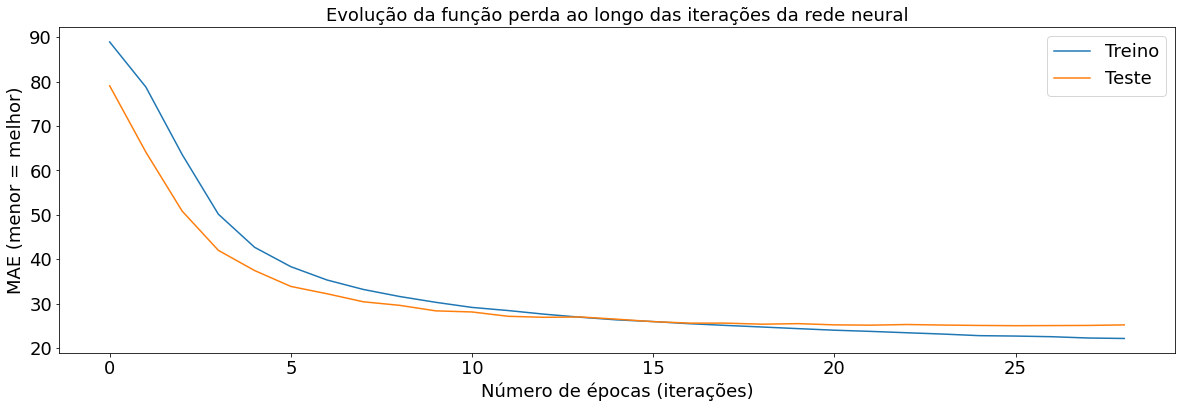

In [68]:
# plot history
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Número de épocas (iterações)',size=18)
plt.ylabel('MAE (menor = melhor)',size=18)
plt.title('Evolução da função perda ao longo das iterações da rede neural',size=18)
plt.legend(['Treino','Teste'],fontsize=18)
plt.show()

Para fazer previsões, usamos o `.predict()`, similar aos modelos em `scikit-learn`

In [69]:
y_pred_nn_train = model.predict(X_train_sc)
y_pred_nn_test = model.predict(X_test_sc)

In [70]:
X_train['pred_nn'] = y_pred_nn_train
X_test['pred_nn'] = y_pred_nn_test
# Prevendo o modelo
y_pred_nn_train = X_train['pred_nn']
y_pred_nn_test = X_test['pred_nn']
# Eliminando colunas auxiliares
X_train.drop('pred_nn',axis=1,inplace=True)
X_test.drop('pred_nn',axis=1,inplace=True)

Vamos comparar essa nova performance do modelo `LSTM` com as que já tínhamos

In [71]:
mae_mdmv = mean_absolute_error(y_valid,y_mediamovel)
y_lstm = pd.Series(y_test_pred,index=y_test.index)
mae_lgbm = mean_absolute_error(y_valid,y_lstm[y_valid.index])
mae_nn = mean_absolute_error(y_valid,y_pred_nn_test[y_valid.index])

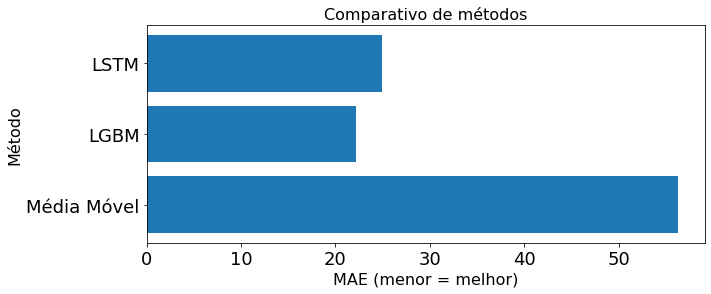

In [72]:
# Plotando os gráficos
performances = [mae_mdmv,mae_lgbm,mae_nn]
plt.figure(figsize=(10,4))
plt.barh(['Média Móvel','LGBM','LSTM'],performances)
plt.ylabel('Método',size=16)
plt.xlabel('MAE (menor = melhor)',size=16)
plt.title('Comparativo de métodos',size=16)
plt.show()

Vamos complementar nosso plot com a rede neural

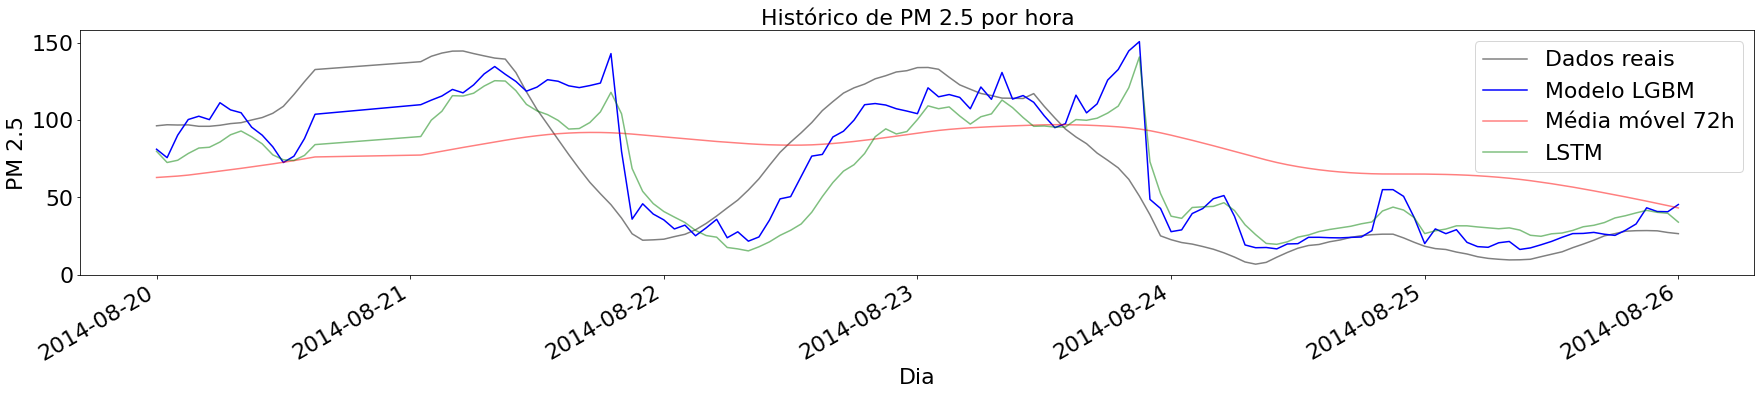

In [73]:
y_nn_plot = y_pred_nn_test[x_pl.index]

plt.figure(figsize=(30,5))
y_plot.plot(c='grey') # Dados reais
y_preds.plot(c='blue') # Dados reais
y_mdmv_plot.plot(c='red',alpha=0.5) # Dados reais
y_nn_plot.plot(c='green',alpha=0.5) # Dados reais
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dia',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico de PM 2.5 por hora',size=22)
plt.legend(['Dados reais','Modelo LGBM','Média móvel 72h','LSTM'],fontsize=22)
plt.show()

## 4. Conclusões!

Foi bastante conteúdo! Mas de tudo o que falamos, queria gravar algumas mensagens importantes sobre séries temporais:

<center> <img src="https://pubwriter.net/images/gif/time.gif" width=500> 


* Em qualquer série temporal, a <b>ordem</b> dos dados importa! Portanto features podem ser extraídas disso, como a média móvel (`rolling`) e as features atrasadas (Pandas `shift`)
* A validação de modelos precisa de uma atenção especial, pois não podemos treinar o futuro pra prever o passado; sendo assim, métodos de validação específicos como o `TimeSeriesSplit` são muito úteis
* Vários algoritmos podem ser tentados, desde os autorregressivos (que usam somente o passado da variável resposta para prever o futuro) até redes neurais recorrentes (como o `LSTM`). Em qualquer dos casos, o teste é essencial para encontrarmos o melhor modelo
* Muitas implementações independentes estão sendo criadas todo dia, então sempre fiquem de olho no que a comunidade divulga (ex: Uber `Orbit` e Facebook `Prophet`)

## 5. Algumas referências interessantes

* Um entendimento mais intuitivo sobre LSTM e Redes Neurais Recorrentes, [aqui](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9#:~:text=To%20train%20a%20recurrent%20neural,propagates%20through%20each%20time%20step.&text=Again%2C%20the%20gradient%20is%20used,thus%20allowing%20it%20to%20learn.)
* Artigo Interessante sobre modelo de previsão de séries de poluição na China usando LSTMs, [aqui](https://www.ischool.berkeley.edu/sites/default/files/sproject_attachments/deep-air-forecasting_final.pdf)
* Livro referência de análise de séries temporais (é bem caro, mas é o melhor): [link](https://www.amazon.com.br/Analysis-Financial-Time-Ruey-Tsay/dp/0470414359/ref=asc_df_0470414359/?tag=googleshopp00-20&linkCode=df0&hvadid=379805270144&hvpos=&hvnetw=g&hvrand=4789316325741000588&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1001773&hvtargid=pla-432446138070&psc=1)

# <center> Muito obrigado a todos!!!
    
<center> <img src="https://s.studiobinder.com/wp-content/uploads/2020/07/Michael-Scott-Wayne-Gretzsky-Quotes.jpg?resolution=1680,0.75" width=1500>